# Application of Machine Learning for the Classification of Corrosion Behavior in Different Environments for Material Selection of Stainless Steels (for Dataset No. 2)

In order to classify the corrosion behavior of stainless steel alloys in the lactic acid solution, following steps are considered according to the attached paper.

Firstly, the necessary libraries are imported.


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree        
import sklearn.metrics     
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
import scipy
import scipy.stats
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from scipy import interp
import sklearn.ensemble
import sklearn.cluster
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
import random
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Step 1: Loading the Data

After preprocessing steps explained elaborately in the paper (Section 2.1), the data will be loaded by running the below cell:

In [2]:
#Loading the input data

Data=pd.read_csv('Dataset No.2.csv')
print(Data.head())

  ASTM Material     C    Mn   Si      P     S    Cr   Mo    Ni    N  ...  Nb   \
0           403  0.15  1.00  0.5  0.040  0.03  11.5  0.0  0.60  0.0  ...  0.0   
1           405  0.08  1.00  1.0  0.040  0.03  11.5  0.0  0.60  0.0  ...  0.0   
2        S41050  0.04  1.00  1.0  0.045  0.03  10.5  0.0  0.60  0.1  ...  0.0   
3           416  0.15  1.25  1.0  0.060  0.35  12.0  0.0  0.00  0.0  ...  0.0   
4           410  0.15  1.00  1.0  0.040  0.03  11.5  0.0  0.75  0.0  ...  0.0   

    Al  Fe balance (%)  Temperature  Behavior Pitting_label  [H+] (mol/dm3)  \
0  0.0          86.180           20      Poor             0          2.6504   
1  0.1          85.650           20      Poor             0          2.6504   
2  0.0          86.685           20      Poor             0          2.6504   
3  0.0          85.190           20      Poor             0          2.6504   
4  0.0          85.530           20      Poor             0          2.6504   

   [OH-] (mol/dm3)  [Cl-] (mol/dm3)  [

In [3]:
#Counting the number of classes our target variable have
Data.groupby('Behavior').count()

,ASTM Material,C,Mn,Si,P,S,Cr,Mo,Ni,N,Ti,Nb,Al,Fe balance (%),Temperature,Pitting_label,[H+] (mol/dm3),[OH-] (mol/dm3),[Cl-] (mol/dm3),[S2-] (mol/dm3)
Behavior,,,,,,,,,,,,,,,,,,,,
Good,311,311,311,311,311,311,311,311,311,311,311,311,311,311,311,311,311,311,311,311
Poor,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226
Resistant,839,839,839,839,839,839,839,839,839,839,839,839,839,839,839,839,839,839,839,839
Severe,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168


In [4]:
#Transform the labels from object (good, poor, Questionable, resistant) to int64 (0,1,2,3)readable by machine for calculating ROC curve

def label_encoder(y):
    le = LabelEncoder()
    Data[y] = le.fit_transform(Data[y])
label_list = ["Behavior"]
for l in label_list:
    label_encoder(l)
Data

,ASTM Material,C,Mn,Si,P,S,Cr,Mo,Ni,N,...,Nb,Al,Fe balance (%),Temperature,Behavior,Pitting_label,[H+] (mol/dm3),[OH-] (mol/dm3),[Cl-] (mol/dm3),[S2-] (mol/dm3)
0,403,0.15,1.00,0.50,0.040,0.03,11.5,0.0,0.60,0.00,...,0.0,0.0,86.180,20,1,0,2.6504,0.0,0.00,0.0
1,405,0.08,1.00,1.00,0.040,0.03,11.5,0.0,0.60,0.00,...,0.0,0.1,85.650,20,1,0,2.6504,0.0,0.00,0.0
2,S41050,0.04,1.00,1.00,0.045,0.03,10.5,0.0,0.60,0.10,...,0.0,0.0,86.685,20,1,0,2.6504,0.0,0.00,0.0
3,416,0.15,1.25,1.00,0.060,0.35,12.0,0.0,0.00,0.00,...,0.0,0.0,85.190,20,1,0,2.6504,0.0,0.00,0.0
4,410,0.15,1.00,1.00,0.040,0.03,11.5,0.0,0.75,0.00,...,0.0,0.0,85.530,20,1,0,2.6504,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,317LN,0.03,2.00,0.75,0.045,0.03,18.0,3.0,11.00,0.10,...,0.0,0.0,65.045,20,2,1,2.9500,0.0,2.95,0.0
1540,329,0.08,1.00,0.75,0.040,0.03,23.0,1.0,2.00,0.00,...,0.0,0.0,72.100,20,2,1,2.9500,0.0,2.95,0.0
1541,S31803,0.03,2.00,1.00,0.030,0.02,21.0,2.5,4.50,0.08,...,0.0,0.0,68.840,20,2,1,2.9500,0.0,2.95,0.0
1542,316Ti,0.08,2.00,0.75,0.045,0.03,16.0,2.0,10.00,0.10,...,0.0,0.0,68.095,20,2,1,2.9500,0.0,2.95,0.0


In [5]:
#Split the data to the training data (80%) and testing data (20%)

X=Data.drop(["ASTM Material","Behavior","Pitting_label"],axis=1)
y=Data["Behavior"]
np.random.seed(0)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True)

## Step 2: Train a decision tree model and accuracy calculation

In this section, the DT model is fitted, and the accuracy of the model is calculated. To improve the accuracy of the model hyperparameter search is also applied. The performance of the model is also analyzed by confusion matrix. This model is selected as the best for Dataset No.2, So the importance of features are sorted in this section. 

In [6]:
#Fitting DT model
decision_tree_model=sklearn.tree.DecisionTreeClassifier(random_state=0).fit(X_train,y_train)

#accuracy calculation
train_accuracy=sklearn.metrics.accuracy_score(y_train, decision_tree_model.predict(X_train))*100
test_accuracy=sklearn.metrics.accuracy_score(y_test, decision_tree_model.predict(X_test))*100

#printing the accuracy
print('Decision Tree Accuracy:')
print(' Train accuracy %.2f%%'%train_accuracy)
print(' Test accuracy  %.2f%%'%test_accuracy)


Decision Tree Accuracy:
 Train accuracy 100.00%
 Test accuracy  90.94%


In [7]:
#hyperparameter search for decision tree

param_dist={"criterion":["gini","entropy"],
           "max_depth":[1,2,3,4,5,6,7,8,9,10,11,12,None]}
clf=sklearn.tree.DecisionTreeClassifier()
grid=GridSearchCV(clf,param_grid=param_dist, cv=10, n_jobs=-1,)
random.seed(0)
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       None]})

In [8]:
#finding the best estimator
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy')

In [9]:
#finding the best score
grid.best_score_

0.9255114083398899

In [10]:
#finding the best parameter
grid.best_params_

{'criterion': 'entropy', 'max_depth': None}

In [11]:
#Re-calculating the accuracies for DT model after hyperparameter search
decision_tree_model=sklearn.tree.DecisionTreeClassifier(random_state=0, max_depth=None, criterion="entropy").fit(X_train,y_train)

#accuracy calculation
train_accuracy=sklearn.metrics.accuracy_score(y_train, decision_tree_model.predict(X_train))*100
test_accuracy=sklearn.metrics.accuracy_score(y_test, decision_tree_model.predict(X_test))*100

#printing the accuracy
print('Decision Tree Accuracy:')
print(' Train accuracy %.2f%%'%train_accuracy)
print(' Test accuracy  %.2f%%'%test_accuracy)

Decision Tree Accuracy:
 Train accuracy 100.00%
 Test accuracy  93.53%


,Feature_names,Importances
14,[H+] (mol/dm3),0.379297
17,[S2-] (mol/dm3),0.203372
12,Fe balance (%),0.195032
6,Mo,0.049978
15,[OH-] (mol/dm3),0.042289
16,[Cl-] (mol/dm3),0.033826
0,C,0.023526
7,Ni,0.017804
3,P,0.014843
5,Cr,0.013215


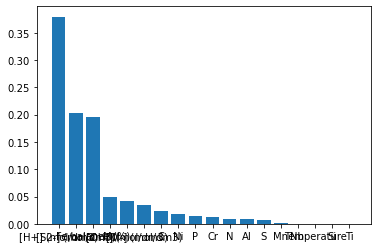

In [12]:
#Feature importance ranking for DT model
decision_tree_model.feature_importances_
df=pd.DataFrame({'Feature_names':X.columns,'Importances':decision_tree_model.feature_importances_})
df_sorted=df.sort_values(by='Importances',ascending=False)
plt.bar(df_sorted['Feature_names'],df_sorted['Importances'])
plt.show
df_sorted

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


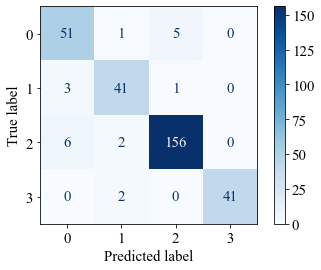

In [13]:
#Confusion matrix for DT

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 15})
plot_confusion_matrix(decision_tree_model, X_test, y_test, cmap='Blues')  
plt.show()

## Step 3: Train SVM, accuracy calculation, and hyperparameter search

In this section, the SVM model with the defult hyperparameter values is fitted, and the accuracy of the model is calculated. Based on the initial accuracies and the results of the confusion matrix, we decided to tune the hyperparameters by hyperparameter search.The performance of the model is also analyzed by confusion matrix before and after hyperparameter tuning. 

In [14]:
#Fitting SVM model
svm_model=sklearn.svm.SVC(kernel='rbf').fit(X_train,y_train)

#Accuracy calculation
train_ac=sklearn.metrics.accuracy_score(y_train, svm_model.predict(X_train)) 
test_ac=sklearn.metrics.accuracy_score(y_test, svm_model.predict(X_test)) 

print('SVM model accuracy:')
print(' Train accuracy %.2f%% '%(train_ac*100)) 
print(' Test accuracy  %.2f%% '%(test_ac*100))

SVM model accuracy:
 Train accuracy 59.03% 
 Test accuracy  53.07% 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


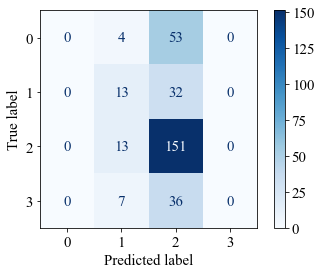

In [15]:
#Confusion matrix for SVM before hypeparameter search

plot_confusion_matrix(svm_model, X_test, y_test, cmap='Blues')  
plt.show()

In [16]:
#Draw samples from reciprocal distribution for searching hyperparameters

C=scipy.stats.reciprocal(1, 100)
gamma=scipy.stats.reciprocal(0.01, 20)
param_distributions={'C':C,'gamma':gamma}
random_search=sklearn.model_selection.RandomizedSearchCV(svm_model, param_distributions,n_iter=20, cv=3, verbose=1, random_state=0).fit(X_train,y_train)
random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


SVC(C=84.5912652804937, gamma=0.18439619501993143)

In [17]:
#Accuracy calculation baesd on the hyperparameter search results (C,gamma) 

rs_train_ac=sklearn.metrics.accuracy_score(y_train, random_search.predict(X_train)) 
rs_test_ac=sklearn.metrics.accuracy_score(y_test, random_search.predict(X_test)) 

print('Random search:')
print(' Train accuracy: %.2f%% '%(rs_train_ac*100)) 
print(' Test accuracy:  %.2f%% '%(rs_test_ac*100))

Random search:
 Train accuracy: 93.20% 
 Test accuracy:  75.40% 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


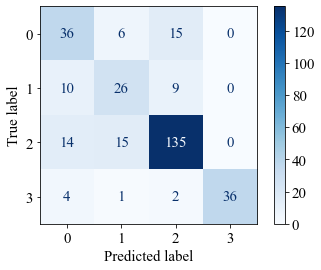

In [18]:
#Confusion matrix after hyperparameter tuning for SVM

plot_confusion_matrix(random_search, X_test, y_test, cmap='Blues')  
plt.show()

## Step 4: Random forest classification

Random Forest Classifier with random_state=0 is fitted to our training data. Also, a hyperparameter search between 1 to 50 is applied to find the best n_estimators for this algorithm. The confusion matrix is also used to analyze the performance of the model.

In [19]:
random_forest=sklearn.ensemble.RandomForestClassifier().fit(X_train,y_train)
accuracy_train=sklearn.metrics.accuracy_score(y_train, random_forest.predict(X_train))
accuracy_test=sklearn.metrics.accuracy_score(y_test, random_forest.predict(X_test))
print('Random Forest')
print(' Train accuracy: %.2f%% '%(accuracy_train*100)) 
print(' Test accuracy:  %.2f%% '%(accuracy_test*100))

Random Forest
 Train accuracy: 99.92% 
 Test accuracy:  73.79% 


In [20]:
accuracies_test=np.array([])

# Finding the index of best test accuracies for n_estimators between 1 to 50

for i in range(1,51):
    random_forest=sklearn.ensemble.RandomForestClassifier(random_state=0, n_estimators=i).fit(X_train,y_train)
    accuracy_test=sklearn.metrics.accuracy_score(y_test, random_forest.predict(X_test))
    accuracies_test=np.hstack((accuracies_test,accuracy_test))
index_test=np.where(accuracies_test==np.amax(accuracies_test))
print(accuracies_test) # print test accuracies of models with n_estimators between 1 to 50
print(index_test)      # print the index of the highest test accuracies

[0.71197411 0.66666667 0.69255663 0.66990291 0.69902913 0.69579288
 0.71197411 0.70550162 0.70873786 0.70226537 0.70226537 0.70550162
 0.71197411 0.71197411 0.7184466  0.7184466  0.71197411 0.72168285
 0.7184466  0.72168285 0.72815534 0.72815534 0.73462783 0.73462783
 0.73786408 0.73462783 0.73786408 0.73462783 0.72815534 0.73462783
 0.73462783 0.73139159 0.73139159 0.72491909 0.73139159 0.72491909
 0.72815534 0.73462783 0.73139159 0.73786408 0.73462783 0.73462783
 0.73786408 0.74110032 0.73786408 0.73786408 0.73786408 0.73786408
 0.73786408 0.74110032]
(array([43, 49]),)


In [21]:
# Fitting random forest model with n_estimators=8 according to one of the indexes obtained in the previous cell

random_forest=sklearn.ensemble.RandomForestClassifier(random_state=0, n_estimators=43).fit(X_train,y_train)
accuracy_train=sklearn.metrics.accuracy_score(y_train, random_forest.predict(X_train))
accuracy_test=sklearn.metrics.accuracy_score(y_test, random_forest.predict(X_test))
print('Random Forest')
print(' Train accuracy: %.2f%% '%(accuracy_train*100)) 
print(' Test accuracy:  %.2f%% '%(accuracy_test*100))

Random Forest
 Train accuracy: 99.84% 
 Test accuracy:  73.79% 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


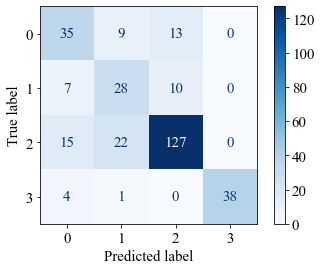

In [22]:
#Confusion matrix for RF model
plot_confusion_matrix(random_forest, X_test, y_test, cmap='Blues')  
plt.show()

 ## Step 5: Bagging classifier

Bagging classifier is fitted to the training data, and the accuracy of the model is increased by hyperparameter tuning.

In [23]:
# Step 5: Bagging classifier
dt=DecisionTreeClassifier()
bag=BaggingClassifier(base_estimator=dt, n_estimators=10, random_state=0)
bag.fit(X_train, y_train)
y_pred=bag.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


Accuracy: 0.8996763754045307


In [24]:
dt = DecisionTreeClassifier()

# Create a BaggingClassifier object with the DecisionTreeClassifier as the base estimator
bag = BaggingClassifier(base_estimator=dt, random_state=0)


params = {
    'n_estimators': [50,60,80],
}

# Use GridSearchCV to search over the hyperparameters
grid_search = GridSearchCV(bag, params, cv=None, scoring='accuracy')
grid_search.fit(X, y)

# Print the best hyperparameters and score
print(f"Best params: {grid_search.best_params_}")

Best params: {'n_estimators': 80}


In [25]:
dt=DecisionTreeClassifier()
bag=BaggingClassifier(base_estimator=dt, n_estimators=80, random_state=0)
bag.fit(X_train, y_train)
y_pred=bag.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.9320388349514563


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


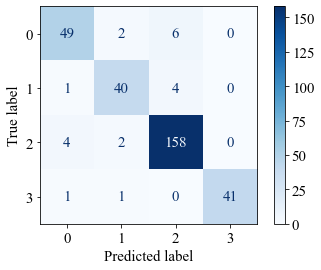

In [26]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 15})
plot_confusion_matrix(bag, X_test, y_test, cmap='Blues')  
plt.show()